In [23]:
import pandas as pd
import csv
import boto3
import pickle
import matplotlib.pyplot as plt
import uuid
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('HotelReservations.csv')

In [3]:
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [ ]:
dynamodb = boto3.resource('dynamodb')
table = dynamodb.Table('HotelReservations')

with open('HotelReservations.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # Adicionar a chave primária
        row['HR'] = str(uuid.uuid4())
        table.put_item(Item=row)

<Axes: xlabel='avg_price_per_room'>

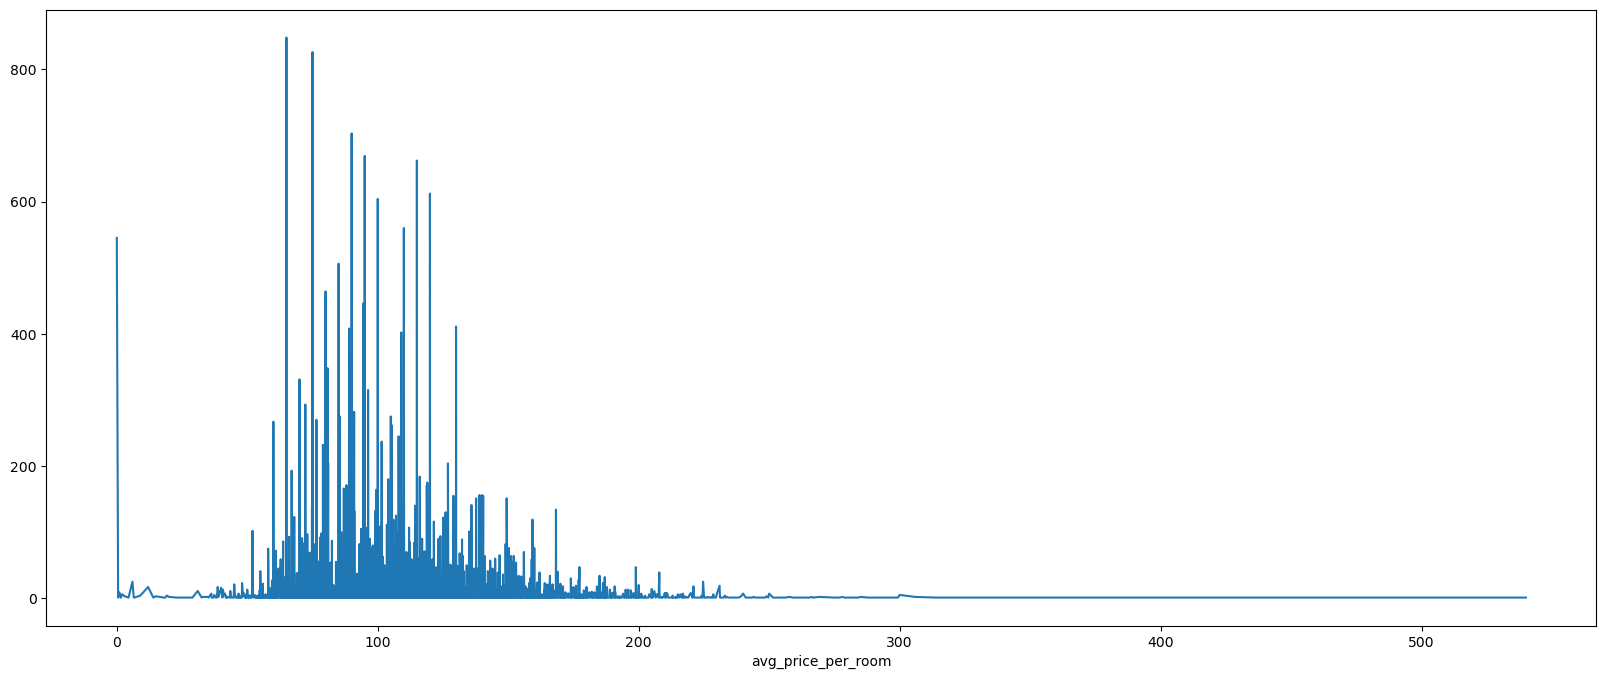

In [4]:
plt.figure(figsize=(20,8))
df['avg_price_per_room'].value_counts().sort_index().plot()

In [5]:
df['label_avg_price_per_room'] = df['avg_price_per_room'].apply(
    lambda x: 1 if x <= 85 else (2 if x < 115 else 3)
)

In [6]:
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,label_avg_price_per_room
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled,1
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled,2
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled,1
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled,2
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled,2


In [ ]:
for index, row in df.iterrows():
    item = row.to_dict()
    # Adicionar a chave primária
    item['HR'] = str(uuid.uuid4())
    table.put_item(Item=item)

In [11]:
X = df.drop(['avg_price_per_room', 'label_avg_price_per_room'], axis=1)
y = df['label_avg_price_per_room']

X = pd.get_dummies(X, columns=['Booking_ID','type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'booking_status'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective='multi:softprob', num_class=3)
xgb_model.fit(X_train, y_train -1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=3,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred + 1)
precision = precision_score(y_test, y_pred + 1, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred + 1, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred + 1, average='weighted')

print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-score: {f1:.3f}')

Accuracy: 0.844
Precision: 0.845
Recall: 0.844
F1-score: 0.844


In [19]:
model_bytes = pickle.dumps(xgb_model)

In [21]:
s3 = boto3.client('s3')
s3.put_object(Body=model_bytes, Bucket='sprint4e5', Key='hotel_reservations_model.pkl')

{'ResponseMetadata': {'RequestId': '62YSBP29CXQ41PCC',
  'HostId': 'r+OMU+RjOYRTeVIGyI0KWSzm46hDjaNzfEwtOe298BRBV28DIwXujQpNQ836VxWhKJFagaKHOio=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'r+OMU+RjOYRTeVIGyI0KWSzm46hDjaNzfEwtOe298BRBV28DIwXujQpNQ836VxWhKJFagaKHOio=',
   'x-amz-request-id': '62YSBP29CXQ41PCC',
   'date': 'Sat, 25 May 2024 23:33:08 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"d5c22596ac5317a8e8fb4c58669e83d1"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"d5c22596ac5317a8e8fb4c58669e83d1"',
 'ServerSideEncryption': 'AES256'}

In [7]:
df.drop(columns=['avg_price_per_room'], inplace=True)

In [8]:
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,no_of_special_requests,booking_status,label_avg_price_per_room
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,0,Not_Canceled,1
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,1,Not_Canceled,2
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,0,Canceled,1
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,0,Canceled,2
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,0,Canceled,2


In [10]:
for index, row in df.iterrows():
    item = row.to_dict()
    # Adicionar a chave primária
    item['HR'] = str(uuid.uuid4())
    table.put_item(Item=item)